## An End-to-End Project on Australian Vineyard Yield (2019)
### By Andrew J. Flighty


### Introduction

This notebook details an end-to-end analysis of Australian vineyard data. In Australia, winemaking is a multi-billion dollar industry that contributes to the economy through production, employment, tourism, and exports. Each year, Australia exports approximately 780 million litres of wine to international markets, making it the world's fifth largest exporter of wine. To promote healthy vineyard production, vineyard managers employ a range of methods to water their wine grapes (e.g. microspray, sprinkler). They may also draw their water from a variety of sources (e.g. groundwater, irrigation channels). Knowledge of factors associated with high vineyard production is of interest to vineyard managers who seek to identify optimal growing conditions and hence minimize costs. Moreover, wine retailers may be interested in general wine production trends in terms of popularity of wine type (red vs. white), wine variety (Shiraz, Chardonnay, etc.), and region of origin.

The purpose of this project is to examine the relationships between watering methods/sources and total vineyard yield. We will further ascertain the popularity of certain wine characteristics, which will shed light on current trends in the Australian wine industry as a whole.

### Approach

In achieving this aim, the following workflow is implemented:

1. Import the public datasets.
2. Clean and preprocess the data.
3. Perform exploratory data analysis. Tableau will be used to facilitate visualisation of geographical data.
4. Model predictors of vineyard yield using machine learning algorithms.
5. Interpret results and draw conclusions.

### Library imports

In [1]:
import numpy as np
import pandas as pd
import re

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Interactive plots
import plotly.graph_objects as go 

# Print all columns
pd.set_option('display.max_columns', None)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Dataset

We are using a dataset on Australian vineyard production, which is publicly available through the Australian Bureau of Statistics (ABS). This dataset is collected every few years through the Vineyard Census. While our dataset describes 2014-2015, it is the most up-to-date version as of 2019. A cursory inspection reveals that estimates vary in their accuracy, with symbols used by the authors to denote the level of confidence in each estimate. This uncertainty must be accomodated for in order to draw accurate conclusions from the dataset.

Vineyard yield has been measured in tonnes of grapes <i>per hectare</i>, and is thus a measure of a region's overall productivity. While yield has been captured at national, state and regional levels, for this project we will be focus on the regional level (a list of recognised wine regions can be found <a href="https://www.wineaustralia.com/market-insights/regional-snapshots">here</a>). Unfortunately, coordinate information (i.e. latitudes and longitudes) are not easily obtained for these  regions because they are difficult to define geographically and often span state boundaries. As such, we have used geographic information <a href="https://www.wineaustralia.com/labelling/geographical-indicators/labelling-gi-australia">available online</a> (accessed 07/02/2019) - in conjunction with latitude and longitude data provided by Google Maps - to create our own set of regional coordinates. For the purpose of data visualisation, this approach will provide a rough geographical indication of vineyard production across Australia.

We will also incorporate another dataset detailing water sources and watering methods for each wine region in the same time period. This dataset is also publicly available through the ABS.

While a large variety of wine varieties are listed, for the following analyses we will focus on four popular _red_ wines (cabernet sauvignon, merlot, pinot noir, shiraz) and four popular _white_ wines (chardonnay, pinot gris, riesling, sauvignon blanc).

## Data importation and preprocessing

In [2]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 42F1-0433

 Directory of C:\Users\ajfli\Portfolio\andrewGit\Project 1 - Australian Vineyards & Wines\Australian Vineyard Yield

01/01/2020  01:11 PM    <DIR>          .
01/01/2020  01:11 PM    <DIR>          ..
30/10/2019  04:53 PM    <DIR>          .ipynb_checkpoints
20/06/2019  05:32 PM           146,811 Australian Vineyard Visualisations.twb
01/01/2020  01:11 PM         5,654,804 Australian Vineyard Yield.ipynb
05/02/2019  01:20 PM         2,040,320 Australian_vineyards.xls
06/02/2019  01:03 PM             2,729 Australian_wine_region_coordinates.csv
01/01/2020  12:16 PM            14,560 Vineyard_data.csv
05/02/2019  01:20 PM           187,904 Water_sources_and_methods.xls
               6 File(s)      8,047,128 bytes
               3 Dir(s)  30,750,425,088 bytes free


In [3]:
# Import government dataset
df = pd.read_excel('Australian_vineyards.xls', 'GI Region')
df.head()

Australian Bureau of Statistics    Unnamed: 1  \
0  1329055002DO001_201415 Vineyards Estimates, Au...           NaN   
1  Released at 11:30 am (Canberra time) Fri 16 Oc...           NaN   
2  Table 3: Vineyards production, area and number...           NaN   
3                                                NaN           NaN   
4                                        Region code  Region label   

              Unnamed: 2 Unnamed: 3                           Unnamed: 4  \
0                    NaN        NaN                                  NaN   
1                    NaN        NaN                                  NaN   
2                    NaN        NaN                                  NaN   
3                    NaN        NaN                                  NaN   
4  Commodity description   Estimate  Estimate - Relative Standard Errors   

                          Unnamed: 5  \
0                                NaN   
1                                NaN   
2                                NaN   
3                                NaN   
4  Number of agricultural businesses   

                                          Unnamed: 6  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4  Number of agricultural businesses - Relative S...

In [4]:
# The first 4 rows and last 8 rows can be dropped
df.drop(df.head(4).index, inplace=True) 
df.drop(df.tail(8).index, inplace=True)
# Relabel columns using names stored in the first row
df.columns = df.iloc[0] 
df.drop(df.index[0], inplace=True)
df.head()

4 Region code          Region label  \
5         111  Murray Darling (NSW)   
6         111  Murray Darling (NSW)   
7         111  Murray Darling (NSW)   
8         111  Murray Darling (NSW)   
9         111  Murray Darling (NSW)   

4                              Commodity description Estimate  \
5  Red wine grapes - Cabernet Sauvignon - Product...  12260.9   
6  Red wine grapes - Cabernet Sauvignon - Bearing...   698.89   
7  Red wine grapes - Cabernet Sauvignon - Area no...    12.87   
8  Red wine grapes - Cabernet Sauvignon - Area no...       20   
9  Red wine grapes - Cabernet Sauvignon - Total a...   731.76   

4 Estimate - Relative Standard Errors Number of agricultural businesses  \
5                                 NaN                                57   
6                                 NaN                                57   
7                                   ^                                 4   
8                                 NaN                                 1   
9                                 NaN                                59   

4 Number of agricultural businesses - Relative Standard Errors  
5                                                NaN            
6                                                NaN            
7                                                  ^            
8                                                NaN            
9                                                NaN

In [5]:
# Inspect object types and row counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10348 entries, 5 to 10352
Data columns (total 7 columns):
Region code                                                     10348 non-null object
Region label                                                    10348 non-null object
Commodity description                                           10348 non-null object
Estimate                                                        10348 non-null object
Estimate - Relative Standard Errors                             4982 non-null object
Number of agricultural businesses                               10348 non-null object
Number of agricultural businesses - Relative Standard Errors    4783 non-null object
dtypes: object(7)
memory usage: 646.8+ KB


In [6]:
# Check missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_application_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
del missing_application_data.index.name
missing_application_data.head(20)

Total  Percent Missing
Number of agricultural businesses - Relative St...   5565        53.778508
Estimate - Relative Standard Errors                  5366        51.855431
Number of agricultural businesses                       0         0.000000
Estimate                                                0         0.000000
Commodity description                                   0         0.000000
Region label                                            0         0.000000
Region code                                             0         0.000000

There are missing values (~50%) only for columns indicating standard errors using symbols (e.g. asterisks). In other words, approximately half of the collected estimates have been labelled with at least some level of uncertainty.

In [7]:
# Transform strings into numerical features, where appropriate
features = ['Estimate', 'Number of agricultural businesses']
for feature in features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce') # 'coerce' replaces any non-numerical values with NaN

In [8]:
# Examine values for standard error columns
print('Types of standard errors for "Estimate":', df['Estimate - Relative Standard Errors'].unique())
print('Number of **:', df[df['Estimate - Relative Standard Errors'] == '*']['Estimate - Relative Standard Errors'].count())
print('Number of *:', df[df['Estimate - Relative Standard Errors'] == '*']['Estimate - Relative Standard Errors'].count())
print('Number of ^:', df[df['Estimate - Relative Standard Errors'] == '^']['Estimate - Relative Standard Errors'].count())

print('\nTypes of standard errors for "Number of agricultural businesses":', df['Number of agricultural businesses - Relative Standard Errors'].unique())
print('Number of **:', df[df['Number of agricultural businesses - Relative Standard Errors'] == '**']['Number of agricultural businesses - Relative Standard Errors'].count())
print('Number of *:', df[df['Number of agricultural businesses - Relative Standard Errors'] == '*']['Number of agricultural businesses - Relative Standard Errors'].count())
print('Number of ^:', df[df['Number of agricultural businesses - Relative Standard Errors'] == '^']['Number of agricultural businesses - Relative Standard Errors'].count())

Types of standard errors for "Estimate": [nan '^' '*' '**']
Number of **: 2092
Number of *: 2092
Number of ^: 2842

Types of standard errors for "Number of agricultural businesses": [nan '^' '*' '**']
Number of **: 45
Number of *: 1730
Number of ^: 3008


According to the ABS spreadsheet, these symbols denote level of confidence in the estimates:

>\** estimate has a relative standard error greater than 50% and is considered too unreliable for general use.

>\* estimate has a relative standard error between 25% and 50% and should be used with caution.

>^ estimate has a relative standard error of 10% to less than 25% and should be used with caution.

For this project, we will only consider estimates with small standard errors, as this will enable greater confidence in the accuracy of our results.

In [9]:
# Drop estimates with a relative standard error of 25% and greater (both \* and \**).
print(f'Number of rows before: {df.shape[0]}')
df = df[df['Estimate - Relative Standard Errors'] != '*']
df = df[df['Estimate - Relative Standard Errors'] != '**']
df = df[df['Number of agricultural businesses - Relative Standard Errors'] != '*']
df = df[df['Number of agricultural businesses - Relative Standard Errors'] != '**']

# Confirm that the procedure was successful
print(f'Number of rows after: {df.shape[0]}')
print('Types of standard errors for Estimate:', df['Estimate - Relative Standard Errors'].unique())
print('Types of standard errors for Number of agricultural businesses:', df['Number of agricultural businesses - Relative Standard Errors'].unique())

Number of rows before: 10348
Number of rows after: 8114
Types of standard errors for Estimate: [nan '^']
Types of standard errors for Number of agricultural businesses: [nan '^']


In [10]:
# Drop columns denoting standard errors
df.drop(columns=['Estimate - Relative Standard Errors',
                 'Number of agricultural businesses - Relative Standard Errors'], inplace=True)

In [11]:
# Examine list of wine regions
print(df['Region label'].unique())
print('\nNumber of regions:', df['Region label'].unique().size)

['Murray Darling (NSW)' 'Perricoota' 'Riverina' 'Swan Hill (NSW)'
 'Big Rivers - Other' 'Western Plains' 'Cowra' 'Mudgee' 'Orange'
 'Central Ranges - Other' 'Canberra District (NSW)' 'Hilltops'
 'Tumbarumba' 'Gundagai' 'Southern New South Wales - Other'
 'Shoalhaven Coast' 'Southern Highlands' 'South Coast - Other'
 'New England Australia' 'Northern Slopes' 'Hastings River'
 'Northern Rivers - Other' 'Hunter' 'Hunter Valley - Other'
 'Murray Darling (Vic.)' 'Swan Hill (Vic.)' 'North West Victoria - Other'
 'Alpine Valleys' 'Beechworth' 'Rutherglen' 'Glenrowan' 'King Valley'
 'North East Victoria - Other' 'Bendigo' 'Goulburn Valley'
 'Strathbogie Ranges' 'Heathcote' 'Upper Goulburn'
 'Central Victoria - Other' 'Grampians' 'Henty' 'Pyrenees'
 'Western Victoria - Other' 'Geelong' 'Mornington Peninsula' 'Sunbury'
 'Yarra Valley' 'Macedon Ranges' 'Port Phillip - Other' 'Gippsland'
 'Granite Belt' 'South Burnett' 'Queensland - Other' 'Adelaide Hills'
 'Clare Valley' 'Adelaide Plains' 'Mount 

In [12]:
# List wines of interest
wine_varieties = ['Cabernet Sauvignon', 'Merlot', 'Pinot Noir', 'Shiraz', 'Chardonnay', 'Pinot Gris', 'Riesling', 'Sauvignon Blanc']

# Remove observations that aren't in the above list
df = df.loc[df['Commodity description'].str.contains('|'.join(wine_varieties))]

In [13]:
# Obtain the number of total businesses for each region
business_df = df.pivot_table(values='Number of agricultural businesses',
               index=['Region label'],
               columns='Commodity description', 
               aggfunc=np.sum)

# Get columns pertaining only to wine production
cols = [c for c in business_df.columns if "Production" in c]
business_df = business_df[cols]
no_of_businesses = business_df.sum(axis=1) # We will later merge this dataframe with our working dataframe

In [14]:
# Drop observations that do not refer to Yield (t/ha) estimates
df = df.loc[df['Commodity description'].str.contains('Yield')]

# Simplify names of wines
for wine in wine_varieties:
    df.loc[df['Commodity description'].str.contains(wine), 'Commodity description'] = wine

In [15]:
# Reshape the dataframe
df = df.pivot_table(values='Estimate', index=['Region label'], columns='Commodity description', aggfunc=np.sum)
df = df.reset_index()

# Create a new column for total yield across all wine varieties
df['Total yield'] = df.sum(axis=1)

df.head()

Commodity description     Region label  Cabernet Sauvignon  Chardonnay  \
0                       Adelaide Hills                4.42        8.60   
1                      Adelaide Plains                6.53       10.22   
2                       Alpine Valleys                2.76       11.78   
3                      Barossa - Other                1.56         NaN   
4                       Barossa Valley                3.67        7.60   

Commodity description  Merlot  Pinot Gris  Pinot Noir  Riesling  \
0                        8.35       11.72        9.27     11.72   
1                        8.27       11.38       10.00      0.00   
2                        8.58       11.54       10.37      3.17   
3                         NaN         NaN         NaN      3.33   
4                        5.48        8.69        8.54      7.18   

Commodity description  Sauvignon Blanc  Shiraz  Total yield  
0                                 9.61    6.52        70.21  
1                                11.41    7.66        65.47  
2                                 7.46    3.32        58.98  
3                                  NaN    1.53         6.42  
4                                 8.08    5.00        54.24

In [16]:
# Get total yield for each wine type
df['Total red yield (t/ha)'] = df[['Cabernet Sauvignon','Merlot','Pinot Noir','Shiraz']].sum(axis=1)
df['Total white yield (t/ha)'] = df[['Chardonnay','Pinot Gris','Riesling','Sauvignon Blanc']].sum(axis=1)

In [17]:
# Import coordinate data for wine regions
coordinates = pd.read_csv('Australian_wine_region_coordinates.csv')
coordinates.head()
# Combine coordinate data with our working dataframe
df = pd.merge(df, coordinates, on = 'Region label')
df.head(5)

Region label  Cabernet Sauvignon  Chardonnay  Merlot  Pinot Gris  \
0   Adelaide Hills                4.42        8.60    8.35       11.72   
1  Adelaide Plains                6.53       10.22    8.27       11.38   
2   Alpine Valleys                2.76       11.78    8.58       11.54   
3  Barossa - Other                1.56         NaN     NaN         NaN   
4   Barossa Valley                3.67        7.60    5.48        8.69   

   Pinot Noir  Riesling  Sauvignon Blanc  Shiraz  Total yield  \
0        9.27     11.72             9.61    6.52        70.21   
1       10.00      0.00            11.41    7.66        65.47   
2       10.37      3.17             7.46    3.32        58.98   
3         NaN      3.33              NaN    1.53         6.42   
4        8.54      7.18             8.08    5.00        54.24   

   Total red yield (t/ha)  Total white yield (t/ha)  Latitude  Longitude  
0                   28.56                     41.65     -34.8      138.9  
1                   32.46                     33.01     -34.6      138.6  
2                   25.03                     33.95     -36.4      146.8  
3                    3.09                      3.33     -34.6      138.9  
4                   22.69                     31.55     -34.5      139.0

In [18]:
# Obtain the total number of agricultural businesses for each region
no_of_businesses = pd.DataFrame(data=no_of_businesses, columns=['Number of agricultural businesses'])
no_of_businesses = no_of_businesses.reset_index()
df = pd.merge(df, no_of_businesses, on = 'Region label')
df.head(5)

Region label  Cabernet Sauvignon  Chardonnay  Merlot  Pinot Gris  \
0   Adelaide Hills                4.42        8.60    8.35       11.72   
1  Adelaide Plains                6.53       10.22    8.27       11.38   
2   Alpine Valleys                2.76       11.78    8.58       11.54   
3  Barossa - Other                1.56         NaN     NaN         NaN   
4   Barossa Valley                3.67        7.60    5.48        8.69   

   Pinot Noir  Riesling  Sauvignon Blanc  Shiraz  Total yield  \
0        9.27     11.72             9.61    6.52        70.21   
1       10.00      0.00            11.41    7.66        65.47   
2       10.37      3.17             7.46    3.32        58.98   
3         NaN      3.33              NaN    1.53         6.42   
4        8.54      7.18             8.08    5.00        54.24   

   Total red yield (t/ha)  Total white yield (t/ha)  Latitude  Longitude  \
0                   28.56                     41.65     -34.8      138.9   
1                   32.46                     33.01     -34.6      138.6   
2                   25.03                     33.95     -36.4      146.8   
3                    3.09                      3.33     -34.6      138.9   
4                   22.69                     31.55     -34.5      139.0   

   Number of agricultural businesses  
0                              543.0  
1                               65.0  
2                               60.0  
3                                5.0  
4                              796.0

In [19]:
# Import water data for wine regions
water_regions = pd.read_excel('Water_sources_and_methods.xls', 'GI Region') # get this specific sheet

# Visual inspection reveals the formatting of this excel spreadsheet is the same as for vineyards dataset.
# For this reason, we can apply the same steps as before to quickly clean the data.
water_regions.drop(water_regions.head(4).index, inplace=True) 
water_regions.columns = water_regions.iloc[0] 
water_regions.drop(water_regions.index[0], inplace=True) 
water_regions.drop(water_regions.tail(8).index, inplace=True)
water_regions.head()

4 Region code          Region label  \
5         111  Murray Darling (NSW)   
6         111  Murray Darling (NSW)   
7         111  Murray Darling (NSW)   
8         111  Murray Darling (NSW)   
9         111  Murray Darling (NSW)   

4                              Data item description Estimate  \
5  Source of water - irrigation channels or irrig...  19267.8   
6  Source of water - water taken from rivers, cre...  24496.7   
7  Source of water - town or country reticulated ...  2148.35   
8  Source of water - total volume of water used (ML)  45912.8   
9  Watering method - spray or sprinkler (excludin...   941.83   

4 Estimate - Relative Standard Errors Number of agricultural businesses  \
5                                 NaN                                66   
6                                 NaN                                53   
7                                 NaN                                 4   
8                                 NaN                               117   
9                                 NaN                                45   

4 Number of agricultural businesses - Relative Standard Errors  
5                                                NaN            
6                                                NaN            
7                                                  ^            
8                                                NaN            
9                                                NaN

In [20]:
# Reshape water data
water_regions = water_regions.pivot_table(values='Estimate',index=['Region label'],columns='Data item description', aggfunc=np.sum)
water_regions = water_regions.reset_index()

# Combine water data with original dataframe
df = pd.merge(df, water_regions, on = 'Region label')
df.head()

Region label  Cabernet Sauvignon  Chardonnay  Merlot  Pinot Gris  \
0   Adelaide Hills                4.42        8.60    8.35       11.72   
1  Adelaide Plains                6.53       10.22    8.27       11.38   
2   Alpine Valleys                2.76       11.78    8.58       11.54   
3  Barossa - Other                1.56         NaN     NaN         NaN   
4   Barossa Valley                3.67        7.60    5.48        8.69   

   Pinot Noir  Riesling  Sauvignon Blanc  Shiraz  Total yield  \
0        9.27     11.72             9.61    6.52        70.21   
1       10.00      0.00            11.41    7.66        65.47   
2       10.37      3.17             7.46    3.32        58.98   
3         NaN      3.33              NaN    1.53         6.42   
4        8.54      7.18             8.08    5.00        54.24   

   Total red yield (t/ha)  Total white yield (t/ha)  Latitude  Longitude  \
0                   28.56                     41.65     -34.8      138.9   
1                   32.46                     33.01     -34.6      138.6   
2                   25.03                     33.95     -36.4      146.8   
3                    3.09                      3.33     -34.6      138.9   
4                   22.69                     31.55     -34.5      139.0   

   Number of agricultural businesses  Source of water - groundwater (ML) (b)  \
0                              543.0                                 3507.81   
1                               65.0                                  301.53   
2                               60.0                                   19.80   
3                                5.0                                    1.00   
4                              796.0                                 2416.12   

   Source of water - irrigation channels or irrigation pipelines (ML)  \
0                                             100.22                    
1                                              63.31                    
2                                                NaN                    
3                                               7.00                    
4                                            3045.24                    

   Source of water - other (ML)  \
0                           NaN   
1                           NaN   
2                           NaN   
3                           NaN   
4                       1926.26   

   Source of water - recycled/re-used water from off-farm sources (ML) (c)  \
0                                              26.57                         
1                                              59.00                         
2                                                NaN                         
3                                                NaN                         
4                                             261.31                         

   Source of water - total volume of water used (ML)  \
0                                            4724.52   
1                                             547.93   
2                                             211.80   
3                                              10.90   
4                                            9893.21   

   Source of water - town or country reticulated mains supply (ML)  \
0                                               9.34                 
1                                               9.45                 
2                                              14.14                 
3                                               2.90                 
4                                            1097.72                 

   Source of water - water taken from on-farm dams or tanks (ML) (a)  \
0                                             936.32                   
1                                               8.27                   
2                                              27.52                   
3                                                NaN               

In [21]:
# Rename columns
df.rename(columns={
 'Region label':
 'Region',
    
 'Cabernet Sauvignon':
 'Cabernet sauvignon yield (t/ha)',
    
 'Chardonnay':
 'Chardonnay yield (t/ha)',
    
 'Merlot':
 'Merlot yield (t/ha)',
    
 'Pinot Gris':
 'Pinot gris yield (t/ha)',
 
 'Pinot Noir':
 'Pinot noir yield (t/ha)',
 
 'Riesling':
 'Riesling yield (t/ha)',
 
 'Sauvignon Blanc':
 'Sauvignon blanc yield (t/ha)',
 
 'Shiraz':
 'Shiraz yield (t/ha)',
 
 'Total yield':
 'Total yield (t/ha)',

 'Source of water - groundwater (ML) (b)':
 'Source of water - groundwater (ML)',
    
 'Source of water - recycled/re-used water from off-farm sources (ML) (c)':
 'Source of water - recycled/re-used water from off-farm sources (ML)',
    
 'Source of water - water taken from on-farm dams or tanks (ML) (a)':
 'Source of source - water taken from on-farm dams or tanks (ML)'}, inplace=True)

In [22]:
# Reorder columns
cols = ['Region',
        'Latitude',
        'Longitude',
        'Total yield (t/ha)',
        'Total red yield (t/ha)',
        'Total white yield (t/ha)',
        'Cabernet sauvignon yield (t/ha)',
        'Chardonnay yield (t/ha)',
        'Merlot yield (t/ha)',
        'Pinot gris yield (t/ha)',
        'Pinot noir yield (t/ha)',
        'Riesling yield (t/ha)',
        'Sauvignon blanc yield (t/ha)',
        'Shiraz yield (t/ha)',
        'Number of agricultural businesses',
        'Source of water - groundwater (ML)',
        'Source of water - irrigation channels or irrigation pipelines (ML)',
        'Source of water - other (ML)',
        'Source of water - recycled/re-used water from off-farm sources (ML)',
        'Source of water - total volume of water used (ML)',
        'Source of water - town or country reticulated mains supply (ML)',
        'Source of source - water taken from on-farm dams or tanks (ML)',
        'Source of water - water taken from rivers, creeks, lakes, etc. (ML)',
        'Watering method - drip or micro spray - area irrigated (ha)',
        'Watering method - furrow or flood - area irrigated (ha)',
        'Watering method - method not reported - area irrigated (ha)',
        'Watering method - other - area irrigated (ha)',
        'Watering method - spray or sprinkler (excluding micro spray) - area irrigated (ha)']
df = df[cols]

df.sample(5)

Region  Latitude  Longitude  Total yield (t/ha)  \
31        Gundagai     -35.0      148.2               34.55   
43        Manjimup     -34.2      116.2               19.61   
19     Eden Valley     -34.6      139.1               46.25   
80  Swan Districts     -31.4      115.9               32.51   
90    Wrattonbully     -37.0      140.8               71.19   

    Total red yield (t/ha)  Total white yield (t/ha)  \
31                   30.55                      4.00   
43                    8.24                     11.37   
19                   17.29                     28.96   
80                   17.36                     15.15   
90                   32.08                     39.11   

    Cabernet sauvignon yield (t/ha)  Chardonnay yield (t/ha)  \
31                             8.43                     0.00   
43                             0.00                     0.94   
19                             3.03                     5.05   
80                             6.92                     6.75   
90                             5.15                     6.87   

    Merlot yield (t/ha)  Pinot gris yield (t/ha)  Pinot noir yield (t/ha)  \
31                 2.00                      NaN                    13.20   
43                 1.92                     4.62                     3.40   
19                 4.08                    10.37                     5.30   
80                 4.62                      NaN                     1.76   
90                 8.74                    12.59                     9.95   

    Riesling yield (t/ha)  Sauvignon blanc yield (t/ha)  Shiraz yield (t/ha)  \
31                    NaN                          4.00                 6.92   
43                    NaN                          5.81                 2.92   
19                    8.3                          5.24                 4.88   
80                    0.0                          8.40                 4.06   
90                   12.1                          7.55                 8.24   

    Number of agricultural businesses  Source of water - groundwater (ML)  \
31                               27.0                               51.64   
43                               20.0                                 NaN   
19                              265.0                              367.87   
80                              146.0                              579.84   
90                              148.0                             3587.00   

    Source of water - irrigation channels or irrigation pipelines (ML)  \
31                                                NaN                    
43                                                NaN                    
19                                              81.18                    
80                                                NaN                    
90                                                NaN                    

    Source of water - other (ML)  \
31                           NaN   
43                           NaN   
19                           NaN   
80                           NaN   
90                           NaN   

    Source of water - recycled/re-used water from off-farm sources (ML)  \
31                                                NaN                     
43                                                NaN                     
19                                               1.26                     
80                                                NaN                     
90                                                NaN                     

    Source of water - total volume of water used (ML)  \
31                                             512.99   
43                                               4.50   
19                                            1965.43   
80                                            1363.30   
90                                            3659.41   

    Source of water - town or country reticulate

In [23]:
# Save output to view on Tableau
df.to_csv('Vineyard_data.csv')

# Exploratory data analysis

In [24]:
df.describe()

Latitude   Longitude  Total yield (t/ha)  Total red yield (t/ha)  \
count  92.000000   92.000000           92.000000               92.000000   
mean  -34.684783  139.960326           45.836413               22.016087   
std     2.812919   10.645552           37.802341               17.127998   
min   -42.000000  115.100000            2.250000                1.140000   
25%   -36.625000  138.750000           24.982500               11.687500   
50%   -34.900000  143.000000           36.065000               17.795000   
75%   -33.900000  146.650000           54.280000               26.547500   
max   -23.100000  152.100000          194.110000               84.010000   

       Total white yield (t/ha)  Cabernet sauvignon yield (t/ha)  \
count                 92.000000                        85.000000   
mean                  23.820326                         5.445529   
std                   21.754918                         4.583028   
min                    0.000000                         0.000000   
25%                    9.812500                         2.150000   
50%                   19.090000                         4.420000   
75%                   30.215000                         6.530000   
max                  110.100000                        19.040000   

       Chardonnay yield (t/ha)  Merlot yield (t/ha)  Pinot gris yield (t/ha)  \
count                86.000000            85.000000                64.000000   
mean                  7.097674             6.540353                 9.053906   
std                   6.121040             5.566640                 6.421642   
min                   0.000000             0.000000                 0.000000   
25%                   3.335000             2.950000                 4.717500   
50%                   5.525000             5.000000                 7.555000   
75%                   8.862500             8.270000                11.420000   
max                  25.960000            27.070000                27.060000   

       Pinot noir yield (t/ha)  Riesling yield (t/ha)  \
count                72.000000              72.000000   
mean                  6.181806               5.824722   
std                   4.903917               5.680121   
min                   0.000000               0.000000   
25%                   3.292500               2.350000   
50%                   4.705000               4.470000   
75%                   8.565000               7.622500   
max                  22.650000              29.900000   

       Sauvignon blanc yield (t/ha)  Shiraz yield (t/ha)  \
count                     75.000000            90.000000   
mean                       7.763200             6.239889   
std                        6.949868             4.982899   
min                        0.000000             0.000000   
25%                        3.795000             3.192500   
50%                        6.220000             5.405000   
75%                        8.845000             7.322500   
max                       34.300000            26.000000   

       Number of agricultural businesses  Source of water - groundwater (ML)  \
count                          92.000000                           71.000000   
mean                          148.326087                          572.210845   
std                           272.509627                         1221.330786   
min                             0.000000                            0.000000   
25%                            23.750000                            7.915000   
50%                            56.000000                           51.640000   
75%                           127.500000                          388.225000   
max                          1987.000000                         5411.540000   

       Source of water - irrigation channels or irrigation pipelines (ML)  \
count                                          47.000000                    
mean                                         4429.138085   

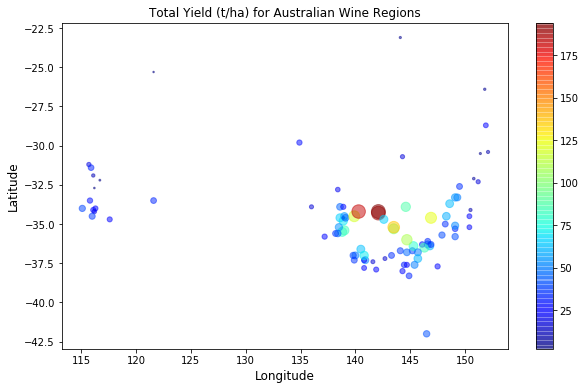

In [25]:
# Visualise total yield as a function of geographical location
plt.figure(figsize=(10, 6))
sc = plt.scatter(x=df['Longitude'], 
            y=df['Latitude'], 
            s=df['Total yield (t/ha)'],
            c=df['Total yield (t/ha)'], 
            alpha=0.5, 
            cmap=plt.get_cmap("jet"));
plt.colorbar(sc)
plt.title('Total Yield (t/ha) for Australian Wine Regions', fontsize=12);
plt.xlabel('Longitude', fontsize=12);
plt.ylabel('Latitude', fontsize=12);

Plotting latitude against longitude coordinates in this manner draws a rough outline of Australia. We can see that there are a two regions in particular with very high vineyard yield.

In [26]:
# Visualise yield of wine varieties
df_wine_varieties = df[['Cabernet sauvignon yield (t/ha)',
                        'Chardonnay yield (t/ha)',
                        'Merlot yield (t/ha)',
                        'Pinot gris yield (t/ha)',
                        'Pinot noir yield (t/ha)',
                        'Riesling yield (t/ha)',
                        'Sauvignon blanc yield (t/ha)',
                        'Shiraz yield (t/ha)']]
df_wine_varieties = df_wine_varieties.sum()
df_wine_varieties = pd.DataFrame({'Wine variety': df_wine_varieties.index, 'Yield (t/ha)': df_wine_varieties.values})
df_wine_varieties['Wine variety'] = df_wine_varieties['Wine variety'].apply(lambda x: x.replace('yield (t/ha)',''))

fig = go.Figure(data=[go.Pie(labels=df_wine_varieties['Wine variety'], values=df_wine_varieties['Yield (t/ha)'], hole=.3)])
fig.update_layout(
    title={
        'text': 'Total Yield (t/ha) for each Wine Variety',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    colorway = ['#fae8af','#f7dd88','#f7d76d','#630404','#bf0a0a','#eb2f2f','#ed5a5a','#f7e9bc'],
    legend={'x':0.8})
fig.show()

Among our list of wine varieties, chardonnay was most popular (14.5%), and riesling was least popular (9.9%). Nevertheless, it is interesting to see that a roughly equal amount of each wine variety was produced in Australia.

In [27]:
# Visualise yield of wine types
df_wine_types = df[['Total red yield (t/ha)','Total white yield (t/ha)']]
df_wine_types = df_wine_types.sum()
df_wine_types = pd.DataFrame({'Wine types': df_wine_types.index, 'Yield (t/ha)': df_wine_types.values})
df_wine_types['Wine types'] = df_wine_types['Wine types'].apply(lambda x: x.replace('Total white yield (t/ha)',' White'))
df_wine_types['Wine types'] = df_wine_types['Wine types'].apply(lambda x: x.replace('Total red yield (t/ha)',' Red'))

fig = go.Figure(data=[go.Pie(labels=df_wine_types['Wine types'], values=df_wine_types['Yield (t/ha)'], hole=0)])
fig.update_layout(
    title={
        'text': 'Total Yield (t/ha) for each Wine Type',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    colorway = ['#fae8af','#bf0a0a'],
    legend={'x':0.8})
fig.show()

Likewise, red and white wine types were produced in very similar quanitites.

In [28]:
# Drop location coordinates and yield for each wine variety, because for the remainder of 
# the EDA we are only interested in total yield vs. all other features
df_eda = df.drop(columns=['Region',
                          'Latitude', 
                          'Longitude',
                          'Total red yield (t/ha)',
                          'Total white yield (t/ha)',
                          'Cabernet sauvignon yield (t/ha)', 
                          'Chardonnay yield (t/ha)', 
                          'Merlot yield (t/ha)', 
                          'Pinot gris yield (t/ha)', 
                          'Pinot noir yield (t/ha)', 
                          'Riesling yield (t/ha)',
                          'Sauvignon blanc yield (t/ha)',
                          'Shiraz yield (t/ha)'], axis=1)
df_eda.head()

Total yield (t/ha)  Number of agricultural businesses  \
0               70.21                              543.0   
1               65.47                               65.0   
2               58.98                               60.0   
3                6.42                                5.0   
4               54.24                              796.0   

   Source of water - groundwater (ML)  \
0                             3507.81   
1                              301.53   
2                               19.80   
3                                1.00   
4                             2416.12   

   Source of water - irrigation channels or irrigation pipelines (ML)  \
0                                             100.22                    
1                                              63.31                    
2                                                NaN                    
3                                               7.00                    
4                                            3045.24                    

   Source of water - other (ML)  \
0                           NaN   
1                           NaN   
2                           NaN   
3                           NaN   
4                       1926.26   

   Source of water - recycled/re-used water from off-farm sources (ML)  \
0                                              26.57                     
1                                              59.00                     
2                                                NaN                     
3                                                NaN                     
4                                             261.31                     

   Source of water - total volume of water used (ML)  \
0                                            4724.52   
1                                             547.93   
2                                             211.80   
3                                              10.90   
4                                            9893.21   

   Source of water - town or country reticulated mains supply (ML)  \
0                                               9.34                 
1                                               9.45                 
2                                              14.14                 
3                                               2.90                 
4                                            1097.72                 

   Source of source - water taken from on-farm dams or tanks (ML)  \
0                                             936.32                
1                                               8.27                
2                                              27.52                
3                                                NaN                
4                                             598.76                

   Source of water - water taken from rivers, creeks, lakes, etc. (ML)  \
0                                             144.26                     
1                                             106.36                     
2                                             150.33                     
3                                                NaN                     
4                                             547.80                     

   Watering method - drip or micro spray - area irrigated (ha)  \
0                                            2711.17             
1                                             491.55             
2                                             118.24             
3                                              14.50             
4                                            8711.69             

   Watering method - furrow or flood - area irrigated (ha)  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                    

In [29]:
# Checking missing data
total = df_eda.isnull().sum().sort_values(ascending = False)
percent = (df_eda.isnull().sum()/df_eda.isnull().count()*100).sort_values(ascending = False)
missing_application_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
del missing_application_data.index.name
missing_application_data.head(20)

Total    Percent
Watering method - other - area irrigated (ha)          82  89.130435
Watering method - furrow or flood - area irriga...     79  85.869565
Source of water - other (ML)                           79  85.869565
Source of water - recycled/re-used water from o...     73  79.347826
Watering method - method not reported - area ir...     68  73.913043
Source of water - town or country reticulated m...     63  68.478261
Source of water - irrigation channels or irriga...     45  48.913043
Watering method - spray or sprinkler (excluding...     42  45.652174
Source of water - water taken from rivers, cree...     33  35.869565
Source of water - groundwater (ML)                     21  22.826087
Source of source - water taken from on-farm dam...     17  18.478261
Watering method - drip or micro spray - area ir...      0   0.000000
Source of water - total volume of water used (ML)       0   0.000000
Number of agricultural businesses                       0   0.000000
Total yield (t/ha)                                      0   0.000000

The high number of missing values is due to the fact that wine regions only have an estimate listed if applicable. For example, a wine region that relies exclusively on the watering method "furrow or flood" will have null values for the remaining methods.

In [30]:
# Visualise popularity of watering methods
df_watering_methods = df[['Watering method - drip or micro spray - area irrigated (ha)',
                        'Watering method - furrow or flood - area irrigated (ha)',
                        'Watering method - method not reported - area irrigated (ha)',
                        'Watering method - other - area irrigated (ha)',
                        'Watering method - spray or sprinkler (excluding micro spray) - area irrigated (ha)']]

df_watering_methods = df_watering_methods.sum()
df_watering_methods = pd.DataFrame({'Watering method': df_watering_methods.index, 'Amount (ha)': df_watering_methods.values})
df_watering_methods['Watering method'] = df_watering_methods['Watering method'].apply(lambda x: x.replace('Watering method - ',''))
df_watering_methods['Watering method'] = df_watering_methods['Watering method'].apply(lambda x: x.replace(' - area irrigated (ha)',''))
df_watering_methods['Watering method'] = df_watering_methods['Watering method'].apply(lambda x: x[0].upper()+x[1:])

fig = go.Figure(data=[go.Pie(labels=df_watering_methods['Watering method'], values=df_watering_methods['Amount (ha)'], hole=.3, pull=[0, 0.1, 0.2, 0.3, 0.1])])
fig.update_layout(
    title={
        'text': 'Area Irrigated (ha) by Watering Method',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    colorway = ['#d4f1fc','#a6e5ff','#81d0f0','#34b7eb','#17bbfc'],
    legend={'x':0.8})
fig.show()

In [31]:
# Visualise popularity of water sources
df_water_sources = df[['Source of water - groundwater (ML)',
                          'Source of water - irrigation channels or irrigation pipelines (ML)',
                          'Source of water - recycled/re-used water from off-farm sources (ML)',
                          'Source of water - town or country reticulated mains supply (ML)',
                          'Source of source - water taken from on-farm dams or tanks (ML)',
                          'Source of water - water taken from rivers, creeks, lakes, etc. (ML)',
                          'Source of water - other (ML)']]

df_water_sources = df_water_sources.sum()
df_water_sources = pd.DataFrame({'Water source': df_water_sources.index, 'Amount (ML)': df_water_sources.values})
df_water_sources['Water source'] = df_water_sources['Water source'].apply(lambda x: x.replace('Source of water - ',''))
df_water_sources['Water source'] = df_water_sources['Water source'].apply(lambda x: x.replace(' (ML)',''))
df_water_sources['Water source'] = df_water_sources['Water source'].apply(lambda x: x[0].upper()+x[1:])

fig = go.Figure(data=[go.Pie(labels=df_water_sources['Water source'], values=df_water_sources['Amount (ML)'], hole=.3, pull=[0, 0.1, 0.2, 0.3, 0.1])])
fig.update_layout(
    title={
        'text': 'Total Volume (ML) of each Water Source',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    colorway = ['#79c6fc','#d4f1fc','#a6e5ff','#81d0f0','#34b7eb','#17bbfc'],
    legend={'x':0.8})
fig.show()

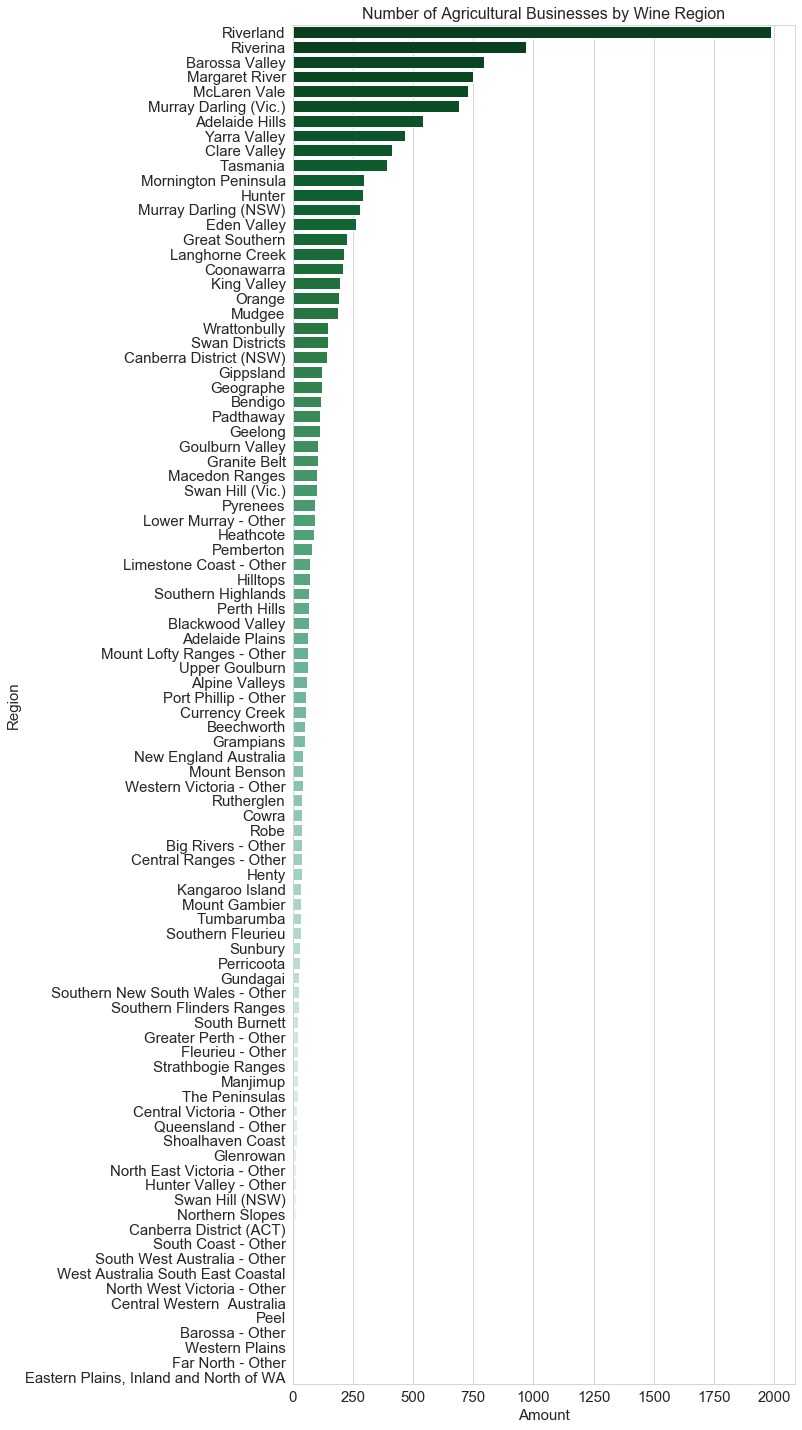

In [32]:
# Examine number of agricultural businesses for each wine region
sorted_df = df.sort_values(by='Number of agricultural businesses', ascending=False)

plt.rcParams['figure.figsize'] = [9, 25]
sns.set_style("whitegrid")
fig = sns.barplot(x='Number of agricultural businesses', y='Region', data=sorted_df, palette='BuGn_r')
fig.set_title('Number of Agricultural Businesses by Wine Region', fontsize = 16)
fig.set_ylabel('Region',fontsize=15)
fig.set_xlabel('Amount',fontsize=15)
fig.tick_params(labelsize=15)

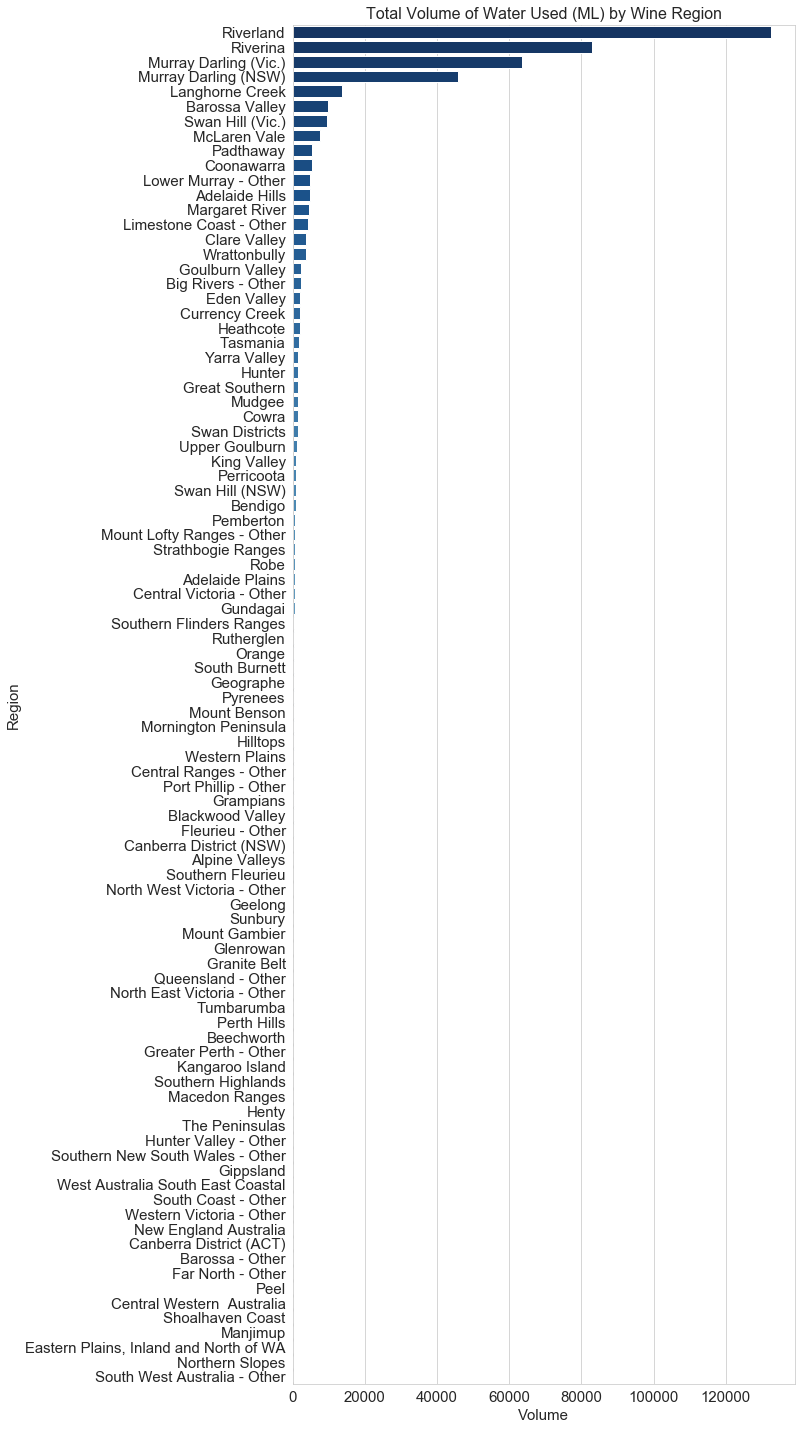

In [33]:
# Examine total volume of water used by wine region
sorted_df = df.sort_values(by='Source of water - total volume of water used (ML)', ascending=False)

plt.rcParams['figure.figsize'] = [9, 25]
sns.set_style('whitegrid')
fig = sns.barplot(x='Source of water - total volume of water used (ML)', y='Region', data=sorted_df, palette='Blues_r')
fig.set_title('Total Volume of Water Used (ML) by Wine Region', fontsize = 16)
fig.set_ylabel('Region',fontsize=15);
fig.set_xlabel('Volume',fontsize=15);
fig.tick_params(labelsize=15)       

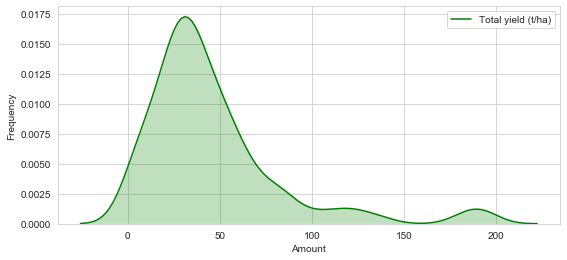

In [34]:
# Examine the distribution of total yield
plt.rcParams['figure.figsize'] = [9, 4]
ax = sns.kdeplot(df_eda['Total yield (t/ha)'], shade=True, color='green')
ax.set(xlabel='Amount', ylabel='Frequency');

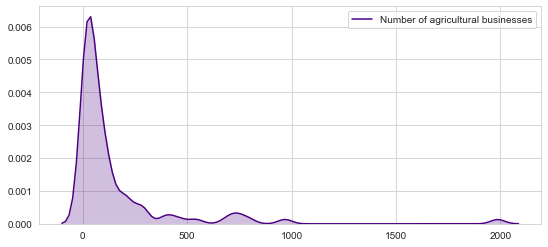

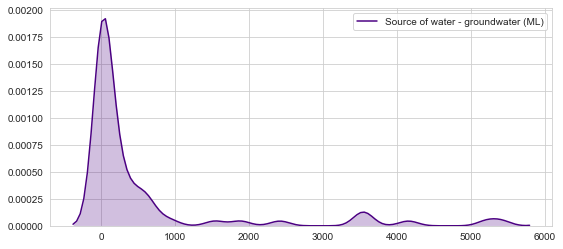

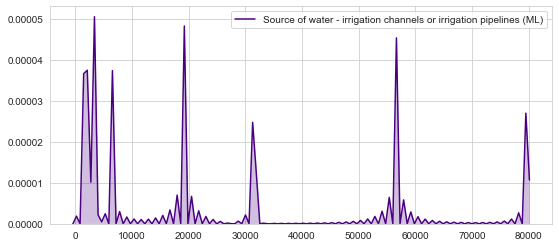

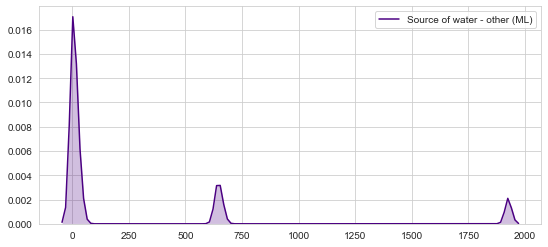

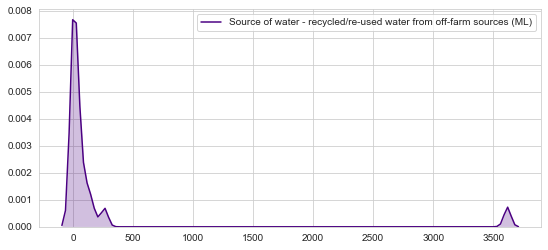

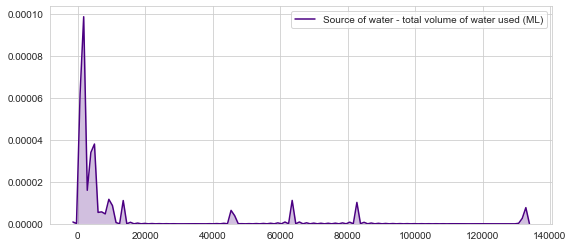

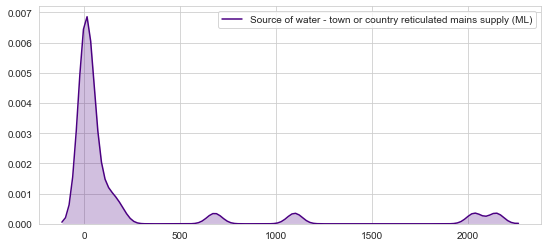

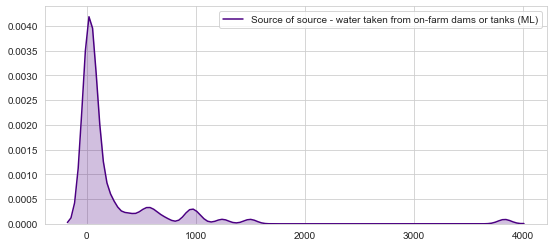

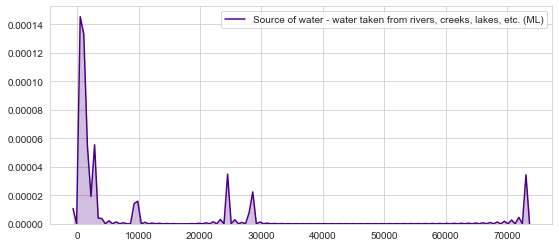

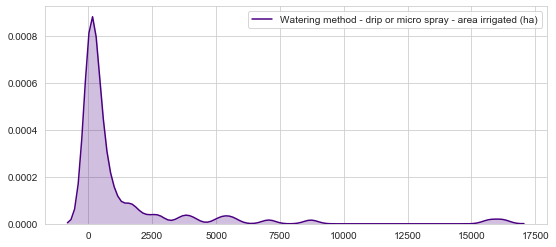

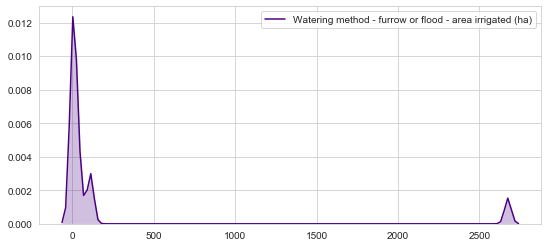

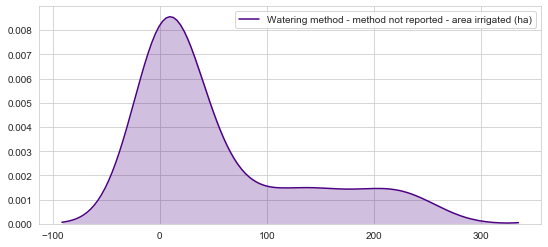

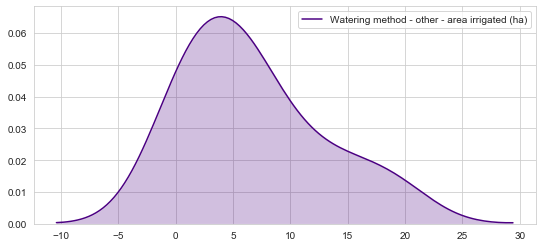

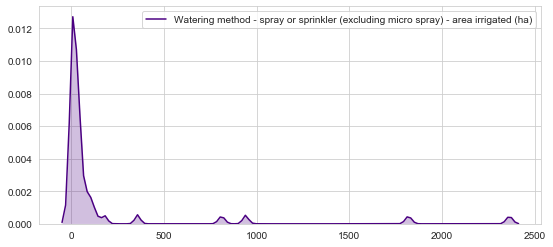

In [35]:
# Examine distributions for remaining features
plt.rcParams['figure.figsize'] = [9, 4]
for i, col in enumerate(df_eda.columns[1:]):
    sns.kdeplot(df_eda[col].dropna(), color='indigo', shade=True)
    plt.show()

All features have positive right skew. We will apply a log transformation to form distributions closer resembling Gaussian.

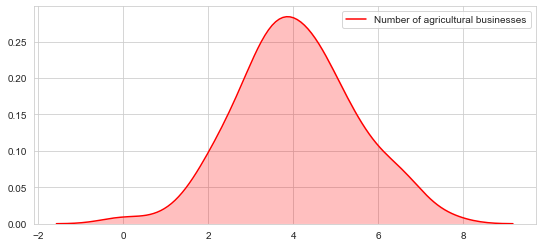

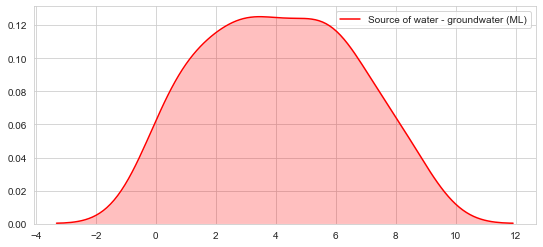

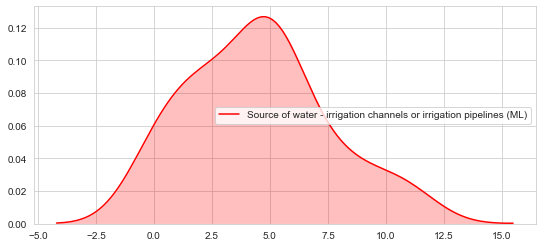

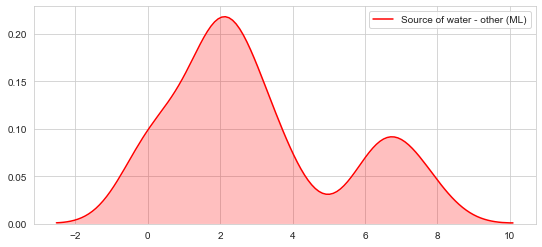

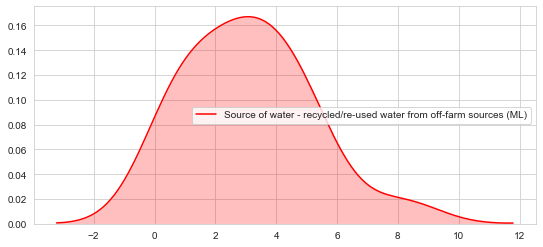

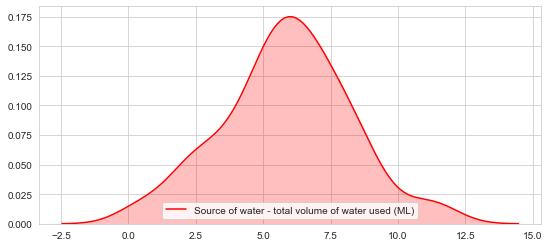

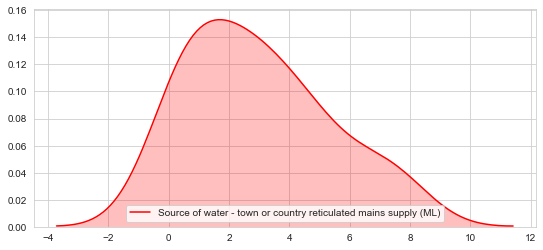

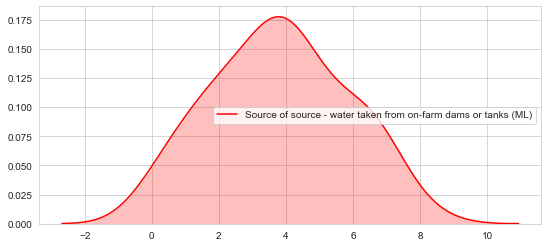

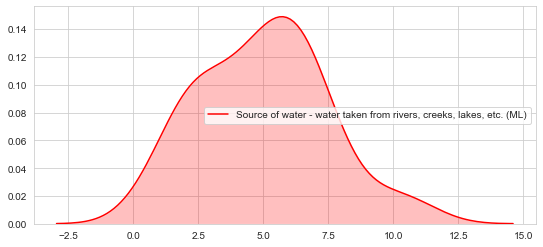

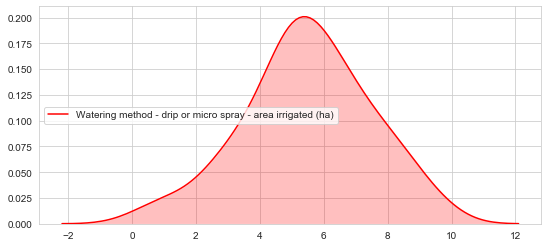

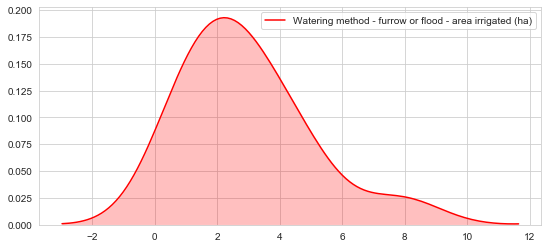

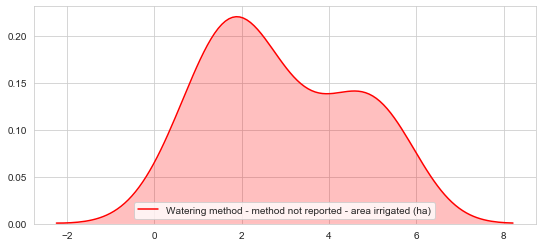

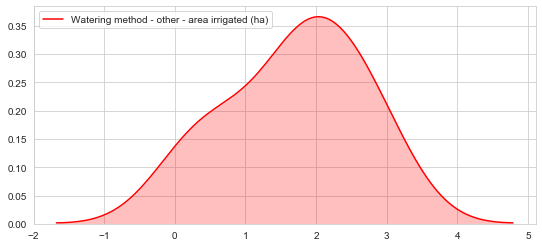

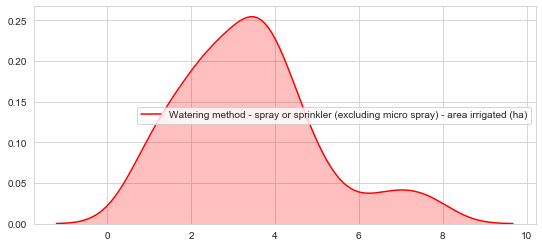

In [36]:
# Log transform all variables except our response (total yield)
df_y = df['Total yield (t/ha)']
df_eda = np.log1p(df_eda)
df_eda['Total yield (t/ha)'] = df_y

# Re-examine distributions
for i, col in enumerate(df_eda.columns[1:]):
    plt.rcParams['figure.figsize'] = [9, 4]
    sns.kdeplot(df_eda[col].dropna(), color='red', shade=True)
    plt.show()

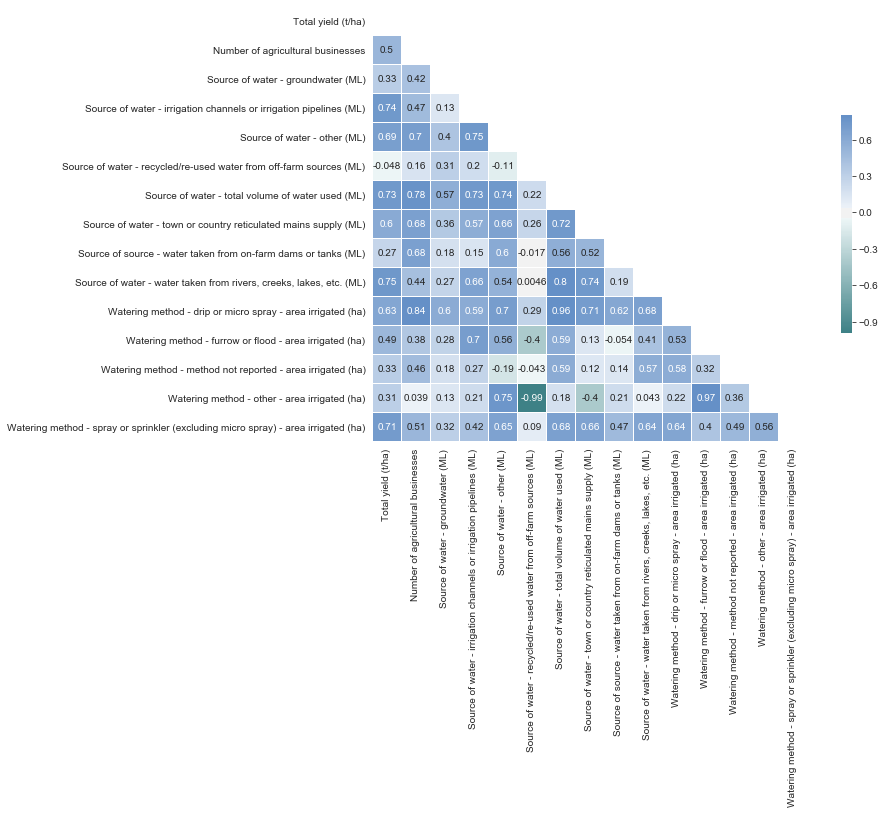

In [37]:
# Get correlation matrix
corrmat = df_eda.corr()
f, ax = plt.subplots(figsize=(12, 8))

# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set colour palette
cmap = sns.diverging_palette(200, 250, as_cmap=True)

# Examine associations between features
sns.heatmap(corrmat, vmax=.8, center = 0, mask=mask, square=True, linewidths=.5, annot=True, cmap=cmap, cbar_kws={"shrink":0.5});

# Fix issue whereby heatmap is "cut off"
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);

We are particularly interested in features associated with total yield. Number of agricultural businesses, as well as a few water features, show quite strong correlations.

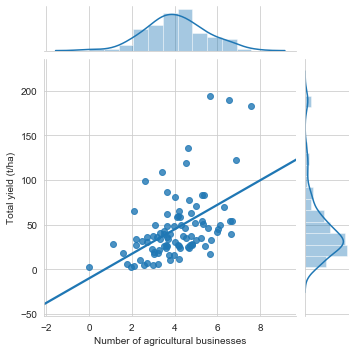

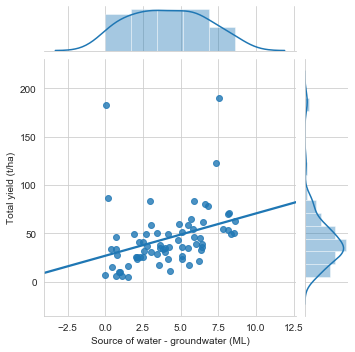

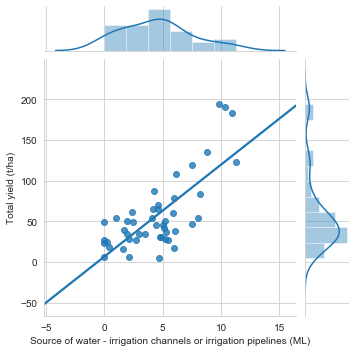

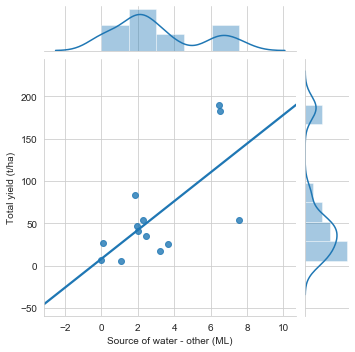

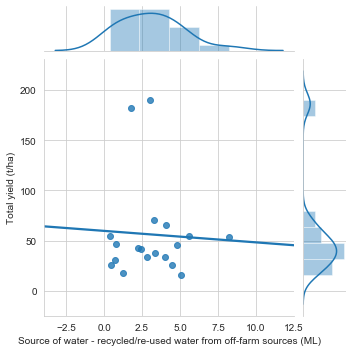

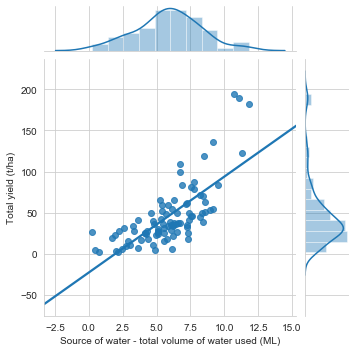

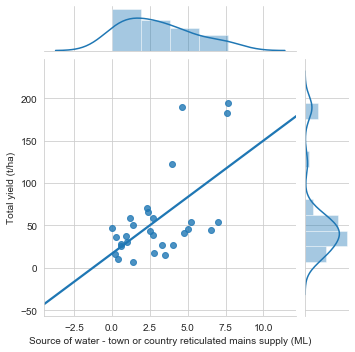

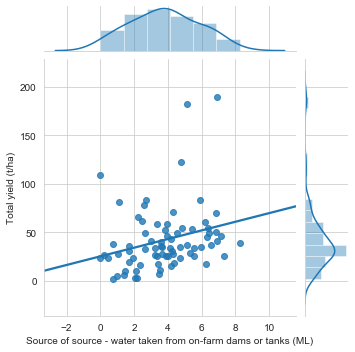

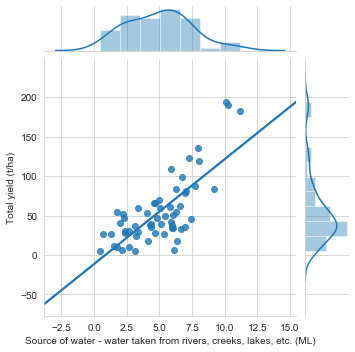

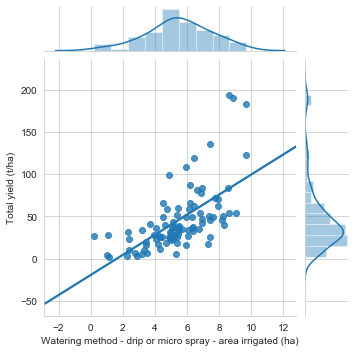

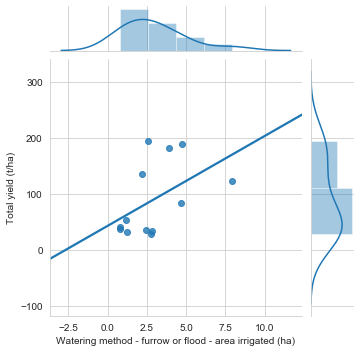

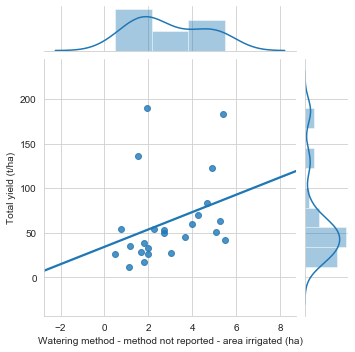

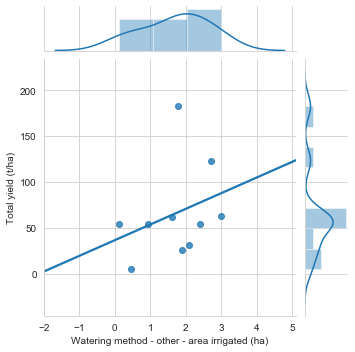

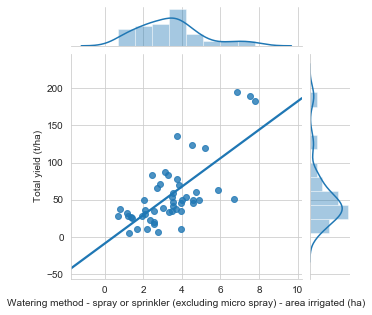

In [38]:
# Examine pairwise associations between total yield and remaining features
for col in df_eda.columns[1:]:
    sns.jointplot(np.log1p(df[col]), df['Total yield (t/ha)'], kind='reg', ci=None, height=5);

We can see small sample sizes for many of the above scatterplots, which may explain why some of the correlations are so high (i.e. they are occuring by chance). Nevertheless, quite a few features look like they will be helpful in predicting vineyard yield. Notably, there are non-linear associations between many features and the response variable.

Unsurprisingly two features - number of agricultural businesses and total volume of water - are related to vineyard yield, and hence will be omitted in predictive modelling in order to better ascertain the predictive potential of merely using water sources/methods.



## Predictive modelling

In [39]:
# Preprocessing libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, PolynomialFeatures, StandardScaler
# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin
class ColumnSelector(BaseEstimator, TransformerMixin):
    """A custom transformer to select a subset of columns"""
    def __init__(self, subset):
        self.subset = subset

    def transform(self, X, *_):
        return X.loc[:, self.subset]

    def fit(self, *_):
        return self

In [40]:
# Identify features of interest
feature_list = ['Source of water - water taken from rivers, creeks, lakes, etc. (ML)',
                'Source of water - irrigation channels or irrigation pipelines (ML)',
                'Source of water - town or country reticulated mains supply (ML)',
                'Watering method - drip or micro spray - area irrigated (ha)',
                'Watering method - spray or sprinkler (excluding micro spray) - area irrigated (ha)']

# Pipeline to preprocess data for machine learning algorithms
pipe = Pipeline([
        ('selector', ColumnSelector(feature_list)), 
        ('imputer', Imputer(strategy="median")),           
        ('standardizer', StandardScaler())])

# Get response vector
df_y = df['Total yield (t/ha)']
# Get feature matrix
df_X = pipe.fit_transform(df.drop(columns='Total yield (t/ha)'))

# Get train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.20)
print(f'Size of training set: {X_train.shape[0]} ({round(len(X_train)/len(df)*100)}%)')
print(f'Size of test set: {X_test.shape[0]} ({round(len(X_test)/len(df)*100)}%)')

Size of training set: 73 (79%)
Size of test set: 19 (21%)


In [41]:
# # # # LINEAR REGRESSION # # # #
def display_cv_scores(scores):
    print("CV RMSE scores:", scores)
    print("CV RMSE mean:", scores.mean())
    print("CV RMSE standard deviation:", scores.std())

# 5-fold CV for linear regression
lreg = LinearRegression()
scores = cross_val_score(lreg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)
display_cv_scores(rmse_scores)

CV RMSE scores: [ 47.65475422 196.59663705  25.70952036  22.43831566  55.62382972]
CV RMSE mean: 69.60461140117192
CV RMSE standard deviation: 64.73897054369257


In [42]:
# # # # RIDGE REGRESSION # # # #
param_grid = [{'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 200, 500, 1000, 2000, 5000]}]

# CV hyperparamater tuning for ridge regression
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {round(np.sqrt(-mean_score),4)}, {param}')
print(f'\nBest RMSE for ridge regression: {round(np.sqrt(-cvres["mean_test_score"].max()),4)}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 83.9952, {'alpha': 0.05}
RMSE: 75.6268, {'alpha': 0.1}
RMSE: 55.956, {'alpha': 0.3}
RMSE: 33.0309, {'alpha': 1}
RMSE: 24.709, {'alpha': 3}
RMSE: 24.8044, {'alpha': 5}
RMSE: 26.1995, {'alpha': 10}
RMSE: 27.1344, {'alpha': 15}
RMSE: 28.561, {'alpha': 30}
RMSE: 29.4121, {'alpha': 50}
RMSE: 29.967, {'alpha': 75}
RMSE: 30.9148, {'alpha': 200}
RMSE: 31.3912, {'alpha': 500}
RMSE: 31.5779, {'alpha': 1000}
RMSE: 31.678, {'alpha': 2000}
RMSE: 31.7404, {'alpha': 5000}

Best RMSE for ridge regression: 24.709
Best hyperparameter(s): {'alpha': 3}


In [43]:
# # # # LASSO REGRESSION # # # #
param_grid = [{'alpha': [2, 3, 5, 10, 15, 30, 50, 75, 200, 500, 1000, 2000, 5000]}]

# CV hyperparamater tuning for lasso regression
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {round(np.sqrt(-mean_score),4)}, {param}')
print(f'\nBest RMSE for lasso regression: {round(np.sqrt(-cvres["mean_test_score"].max()),4)}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 30.2047, {'alpha': 2}
RMSE: 31.1276, {'alpha': 3}
RMSE: 31.5669, {'alpha': 5}
RMSE: 31.5608, {'alpha': 10}
RMSE: 31.7797, {'alpha': 15}
RMSE: 31.7832, {'alpha': 30}
RMSE: 31.7832, {'alpha': 50}
RMSE: 31.7832, {'alpha': 75}
RMSE: 31.7832, {'alpha': 200}
RMSE: 31.7832, {'alpha': 500}
RMSE: 31.7832, {'alpha': 1000}
RMSE: 31.7832, {'alpha': 2000}
RMSE: 31.7832, {'alpha': 5000}

Best RMSE for lasso regression: 30.2047
Best hyperparameter(s): {'alpha': 2}


In [44]:
# # # # RANDOM FOREST REGRESSOR # # # #
param_grid = [
    {'n_estimators': [10, 20, 50, 100, 200],
     'max_features': [1, 2, 3, 4, 5]}]

# CV hyperparameter tuning for random forest
rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
rf_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {round(np.sqrt(-mean_score),4)}, {param}')
print(f'\nBest RMSE for random forest: {round(np.sqrt(-cvres["mean_test_score"].max()),2)}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 24.7405, {'max_features': 1, 'n_estimators': 10}
RMSE: 22.8081, {'max_features': 1, 'n_estimators': 20}
RMSE: 22.9199, {'max_features': 1, 'n_estimators': 50}
RMSE: 23.8687, {'max_features': 1, 'n_estimators': 100}
RMSE: 23.3871, {'max_features': 1, 'n_estimators': 200}
RMSE: 22.5117, {'max_features': 2, 'n_estimators': 10}
RMSE: 21.909, {'max_features': 2, 'n_estimators': 20}
RMSE: 22.374, {'max_features': 2, 'n_estimators': 50}
RMSE: 22.5678, {'max_features': 2, 'n_estimators': 100}
RMSE: 22.5601, {'max_features': 2, 'n_estimators': 200}
RMSE: 23.5569, {'max_features': 3, 'n_estimators': 10}
RMSE: 24.003, {'max_features': 3, 'n_estimators': 20}
RMSE: 22.9593, {'max_features': 3, 'n_estimators': 50}
RMSE: 22.7105, {'max_features': 3, 'n_estimators': 100}
RMSE: 22.7442, {'max_features': 3, 'n_estimators': 200}
RMSE: 23.4047, {'max_features': 4, 'n_estimators': 10}
RMSE: 22.1116, {'max_features': 4, 'n_estimators': 20}
RMSE: 22.6459, {'max_features': 4, 'n_estimators': 50}
RMSE: 2

Random forest had the lowest RMSE when compared to ordinary least squares, ridge and lasso regression. To validate results, we will fit the random forest model with optimal hyperparameters to the test set. 

RMSE on test dataset: 19.373
R-squared on test dataset: 0.8552


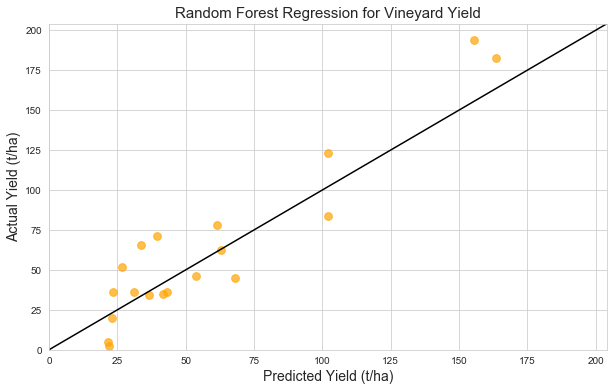

In [45]:
y_pred = rf_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE on test dataset:', round(rmse, 4))
r_sq = r2_score(y_test, y_pred)
print('R-squared on test dataset:', round(r_sq, 4))

# Plot actual vs. predicted
plt.figure(figsize=(10, 6))
sns.regplot(y_pred, y_test, ci=None, fit_reg=False, color='orange', marker='o', scatter_kws={'s':60, 'alpha':0.7});
plt.title('Random Forest Regression for Vineyard Yield', fontsize=15);
plt.ylabel('Actual Yield (t/ha)', fontsize=14);
plt.xlabel('Predicted Yield (t/ha)', fontsize=14);
axis_limit = max(y_test.max(), y_pred.max())+10
plt.xlim(0, axis_limit);
plt.ylim(0, axis_limit);

# Add y=x line, representing perfect prediction accuracy
y_lim = plt.ylim()
x_lim = plt.xlim()
plt.plot(x_lim, y_lim, '-', color = 'k');

The RMSE only increased somewhat on the test set, which suggests good generalizability of our model. We will not fit the model to the entire dataset in order to better examine feature importances.

RMSE on full dataset: 9.33
R-squared on full dataset: 0.96


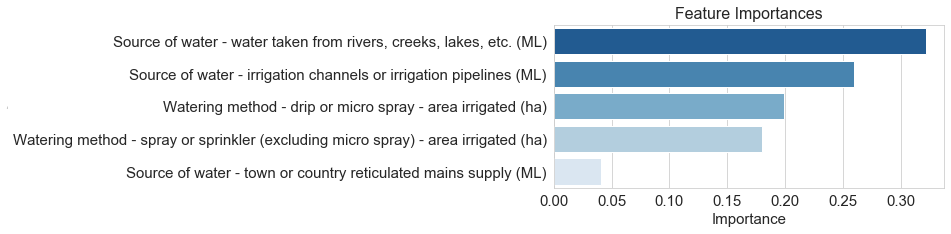

In [46]:
# # # # FINAL MODEL # # # #
# Refit random forest on entire dataset
rf_final = RandomForestRegressor(max_features=rf_best.max_features,
                                 n_estimators=rf_best.n_estimators)
rf_final.fit(df_X, df_y)
y_pred = rf_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE on full dataset:', round(rmse, 2))
r_sq = r2_score(y_pred, y_test)
print('R-squared on full dataset:', round(r_sq, 2))

# Obtain and plot feature importances
df_importances = pd.DataFrame(data={'Feature':feature_list,'Importance':rf_final.feature_importances_})
df_importances = df_importances.sort_values(by='Importance', ascending=False)
plt.rcParams['figure.figsize'] = [7, 3]
sns.set_style('whitegrid')
fig = sns.barplot(x='Importance', y='Feature', data=df_importances, palette='Blues_r')
fig.set_title('Feature Importances', fontsize = 16)
fig.set_ylabel('Feature',fontsize=0);
fig.set_xlabel('Importance',fontsize=15);
fig.tick_params(labelsize=15)    

## Conclusion

We were able to analyze and present key findings of the ABS Vineyard Census, particularly for associations between watering sources/methods and total vineyard yield. We were further able to visualise trends on a range of wine characteristics of interest, including wine type, variety, and region of origin. Tableau software in particular was helpful in visualising the geographical elements associated with the dataset, including total vineyard yield for each region.

Take-home findings are as follows:
1. Vineyard yield was highest in the Murray-Darling basin, a region spanning both Victoria and New South Wales.
2. Chardonnay was the most popular wine variety (14.5%); riesling was least popular (9.9%). Nevertheless, all eight wine varieties were mostly equally represented.
3. Yields for red and white wines were evenly split, with the majority of regions producing approximately equal amounts of both types.
4. The most popular watering <i>method</i> was drip or micro spray (90.2%); the least popular was recycled/re-used water from off-farm sources (2.4%).
5. The most popular water <i>source</i> was irrigation channels or irrigation pipelines (47.3%); the least popular was furrow or flood (1.0%).
6. A predictive model explained found that water taken from rivers, creeks, lakes, etc. was the important predictor for total vineyard yield, with higher use (in megalitres) associated with higher total yield. 
7. Vineyard yield had an average prediction error of 19.37 (t/ha). Given that most regional yields range from 8 and 82 (t/ha), this error level may or may not be considered adequate for business decision-making. Nevertheless, this result is quite good given that we have relied exclusively on watering sources/methods as predictors.

Overall, findings suggest that choice of watering methods/sources play a key role in vineyard yield, which has implications for vineyard managers who seek to maximize grape production. However, a couple of caveats must be noted. Firstly, increased profits (though higher vineyard yield) may not be offset by the increased cost in adopting more sophisticated watering sources/methods. Secondly, we cannot conclude that higher use of these watering sources/methods <i>causes</i> higher vineyard yield; further research could elucidate mechanisms by which these features promote vineyard yield, which may instil greater confidence in the model proposed here.


### Sources
https://data.gov.au/dataset/ds-sa-3eaf0947-f0a8-4206-80fd-98ec2d159d78/details

https://en.wikipedia.org/wiki/Australian_wine

https://www.wineaustralia.com/market-insights/regional-snapshots